In [10]:
import os
import numpy as np
import cv2
import json 

# ------------------------------
# ENTER YOUR REQUIREMENTS HERE:
ARUCO_DICT = cv2.aruco.DICT_4X4_50
SQUARES_VERTICALLY = 5
SQUARES_HORIZONTALLY = 7
SQUARE_LENGTH = 0.03  # in meters
MARKER_LENGTH = 0.015  # in meters
# ...
PATH_TO_YOUR_IMAGES = 'testdata/charuco_calib_set_1/'
print(f"{ARUCO_DICT=}")
# ------------------------------

json_file_path = './calibration.json'

with open(json_file_path, 'r') as file: # Read the JSON file
    json_data = json.load(file)

mtx = np.array(json_data['mtx'])
dst = np.array(json_data['dist'])

dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, params)

ARUCO_DICT=0


In [11]:
image_paths = [os.path.join(PATH_TO_YOUR_IMAGES, f) for f in os.listdir(PATH_TO_YOUR_IMAGES) if f.endswith(".JPG")]

img_path = image_paths[12] # select image
image_color = cv2.imread(img_path)
image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

h,  w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dst, (w,h), 1, (w,h))
image = cv2.undistort(image, mtx, dst, None, newcameramtx)

all_charuco_ids = []
all_charuco_corners = []


marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)
if marker_ids is not None and len(marker_ids) > 0: # If at least one marker is detected
    # cv2.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids)
    ret, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)

    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, np.array(mtx), np.array(dst), np.empty(1), np.empty(1))

    Zx, Zy, Zz = tvec[0][0], tvec[1][0], tvec[2][0]
    fx, fy = mtx[0][0], mtx[1][1]

else:
    print("no marker detected")


In [12]:
%matplotlib widget

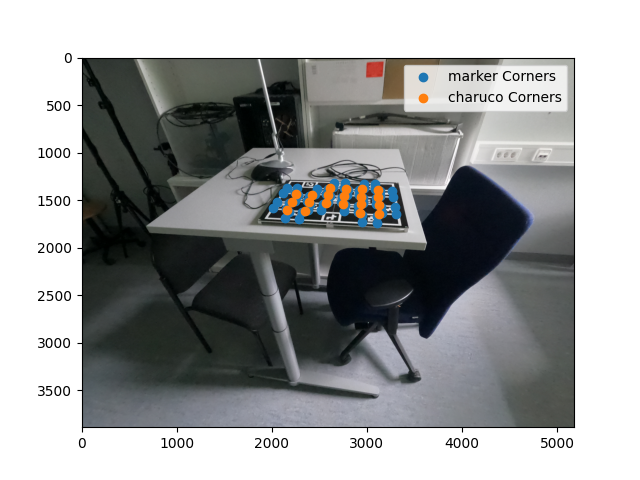

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(np.hstack(marker_corners)[0,:,0],np.hstack(marker_corners)[0,:,1],label="marker Corners")
plt.scatter(charucoCorners[:,0,0],charucoCorners[:,0,1], label="charuco Corners")
plt.legend()

In [14]:
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Camera pose: the inverse of the extrinsic matrix (rotation + translation)
camera_pose = np.eye(4)
camera_pose[:3, :3] = rotation_matrix
camera_pose[:3, 3] = tvec.flatten()
camera_mat = np.eye(4)
camera_mat[:3,:3] = mtx
P = camera_mat @ camera_pose
P = P[:3,:] # we only had 4 rows for multiplication before
world_corners = board.getChessboardCorners()
image_pts = P @ np.hstack((world_corners,np.ones((world_corners.shape[0],1)))).T
# recover homogeneous coordinates
image_pts = image_pts / image_pts[-1,:]
image_pts = image_pts[:2,:]
image_pts.T

array([[2163.23365931, 1605.07430717],
       [2212.73257331, 1516.48815318],
       [2256.9064407 , 1437.43201433],
       [2296.57070196, 1366.44653059],
       [2348.08615561, 1613.28339841],
       [2387.46967068, 1523.33306448],
       [2422.57596216, 1443.15173387],
       [2454.06593535, 1371.22992599],
       [2536.93440632, 1621.66993661],
       [2565.76477822, 1530.31735239],
       [2591.43391418, 1448.98153358],
       [2614.4347361 , 1376.10059648],
       [2729.9094211 , 1630.23973975],
       [2747.72772067, 1537.44531903],
       [2763.57326899, 1454.92462331],
       [2777.75650313, 1381.06095353],
       [2927.14788874, 1638.99887803],
       [2933.47278483, 1544.72144131],
       [2939.09054992, 1460.98433552],
       [2944.1134939 , 1386.11349543],
       [3128.79277928, 1647.95370059],
       [3123.11922198, 1552.15039063],
       [3118.08626058, 1467.16414008],
       [3113.59119831, 1391.26081865]])

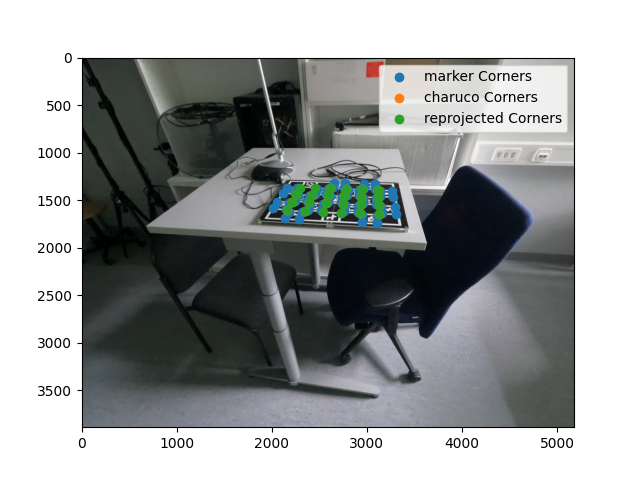

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(np.hstack(marker_corners)[0,:,0],np.hstack(marker_corners)[0,:,1],label="marker Corners")
plt.scatter(charucoCorners[:,0,0],charucoCorners[:,0,1], label="charuco Corners")
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected Corners")
plt.legend()


successfully overlaid corners mean that returned rvec and tvec are indeed the camera pose. Note that because of opencv the image origin is top left

In [16]:
image_pts

array([[2163.23365931, 2212.73257331, 2256.9064407 , 2296.57070196,
        2348.08615561, 2387.46967068, 2422.57596216, 2454.06593535,
        2536.93440632, 2565.76477822, 2591.43391418, 2614.4347361 ,
        2729.9094211 , 2747.72772067, 2763.57326899, 2777.75650313,
        2927.14788874, 2933.47278483, 2939.09054992, 2944.1134939 ,
        3128.79277928, 3123.11922198, 3118.08626058, 3113.59119831],
       [1605.07430717, 1516.48815318, 1437.43201433, 1366.44653059,
        1613.28339841, 1523.33306448, 1443.15173387, 1371.22992599,
        1621.66993661, 1530.31735239, 1448.98153358, 1376.10059648,
        1630.23973975, 1537.44531903, 1454.92462331, 1381.06095353,
        1638.99887803, 1544.72144131, 1460.98433552, 1386.11349543,
        1647.95370059, 1552.15039063, 1467.16414008, 1391.26081865]])

In [17]:
camera_pose

array([[ 0.14669203,  0.98858238,  0.03444297, -0.09896914],
       [-0.60642233,  0.06236669,  0.7926931 , -0.03916132],
       [ 0.78149435, -0.13716875,  0.60864713,  0.36964312],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [18]:
import plotly.graph_objects as go
from stl import mesh
def plot_3d_points_and_camera_centers(points, extrinsic_matrices):
    """
    Plots a 3D scatter plot of the given points and camera representations from extrinsic matrices.

    Parameters:
    - points: A 3xN NumPy array, where each column represents a point (x, y, z).
    - extrinsic_matrices: A list of 4x4 NumPy arrays representing the extrinsic matrices for each camera.
    """
    # Ensure points is a NumPy array
    points = np.asarray(points)

    # Check if the input is a 3xN array
    if points.shape[0] != 3:
        raise ValueError("Input points must be a 3xN NumPy array.")

    # Extract x, y, z coordinates
    x = points[0, :]
    y = points[1, :]
    z = points[2, :]

    # Create a 3D scatter plot for the points
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=5,
            color='blue',  # Marker color for points
            opacity=0.8
        ),
        name='3D Points'
    )])

    # Function to create a cone shape for the camera representation
    def create_camera_cone(extrinsic):
        # Transform the cone points using the extrinsic matrix
        camera_center = extrinsic[:3, 3]
        rotation_matrix = extrinsic[:3, :3]


        def rotate_and_translate(vertices, rotation_matrix, translation_vector):
            # Apply rotation
            rotated_vertices = vertices @ rotation_matrix.T  # Ensure correct shape
            # Apply translation
            translated_vertices = rotated_vertices + translation_vector
            return translated_vertices

        # Load the STL file
        your_mesh = mesh.Mesh.from_file('pyramid.stl')

        # Extract vertices
        vertices = your_mesh.vectors.reshape(-1, 3)

        # Rotate and translate the frustum
        transformed_vertices = rotate_and_translate(vertices, rotation_matrix, camera_center)
        # compute forward vector 
        frustum = go.Mesh3d(
            x=transformed_vertices[:, 0],
            y=transformed_vertices[:, 1],
            z=transformed_vertices[:, 2],
            opacity=0.75,
            color='blue'
        )

        return frustum

    # Plot camera representations from extrinsic matrices
    for idx, extrinsic in enumerate(extrinsic_matrices):
        # Create the camera cone
        cone_points = create_camera_cone(extrinsic)

        # Add the cone to the plot
        fig.add_trace(cone_points)

    # Set the layout
    fig.update_layout(
        title='3D Scatter Plot of Points and Camera Representations',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        )
    )

    # Show the figure in the Jupyter Notebook
    fig.show()


# Define a list of extrinsic matrices (4x4)
extrinsic_matrices = [
    camera_pose
]

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(world_corners.T, extrinsic_matrices)